## What we need 

Get data from WRDS --> is this through openAP

get fama french factors? 

How do we get the long-short positions?? like how do we see the returns?

are we able to get wrds connection or should we get a file downloaded from you 

will we be able to use gridsearchCV to run multiple models at once?

In [2]:
DEV = True # will shrink datasets after loading


In [3]:
import pandas as pd
import polars as pl

import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
crsp = pd.read_csv('crsp_data.csv')
crsp.info()

# for speedy dev, pick 20 permnos at random (with seed)
if DEV:
    np.random.seed(123)
    permnos = crsp['permno'].unique()
    permnos = np.random.choice(permnos, size=20, replace=False)
    crsp = crsp[crsp['permno'].isin(permnos)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   permno  int64  
 1   date    object 
 2   ret     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 92.6+ MB


In [5]:
# crsp = pl.from_pandas(crsp)

crsp['date'] = pd.to_datetime(crsp['date'])

cleancrsp = crsp.query('ret.notnull() and date.dt.year >= 1975')
#crsp["ret"].is_not_null(), crsp['date'].dt.year() >= 1975) 
# keep only the data that has return and after 1975

len(cleancrsp['ret'].notnull()) # check that no null values in ret
len(cleancrsp['ret'].notnull()) == len(cleancrsp) # check that all ret values are not null

cleancrsp


,permno,date,ret
29180,10181,1986-05-30,6.8493
29181,10181,1986-06-30,16.6667
29182,10181,1986-07-31,1.0989
29183,10181,1986-08-29,-6.5217
29184,10181,1986-09-30,-4.6512
...,...,...,...
4037917,93235,2014-04-30,17.2319
4037918,93235,2014-05-30,-1.3066
4037919,93235,2014-06-30,5.7683
4037920,93235,2014-07-31,-2.9951


In [5]:
max_idx = cleancrsp['ret'].argmax()

cleancrsp.iloc[max_idx-5:max_idx+5] # this seems like an outlier for sure, not to be included in the data --> company is black stone minerals. 

,permno,date,ret
1789840,42076,1975-06-30,0.0000
1789841,42076,1975-07-31,8.3333
1789842,42076,1975-08-29,0.0000
1789843,42076,1975-09-30,-15.3846
1789844,42076,1975-10-31,-9.0909
2352007,61241,1975-01-31,147.0588
2352008,61241,1975-02-28,21.4286
2352009,61241,1975-03-31,33.3333
2352010,61241,1975-04-30,2.9412
2352011,61241,1975-05-30,31.4286


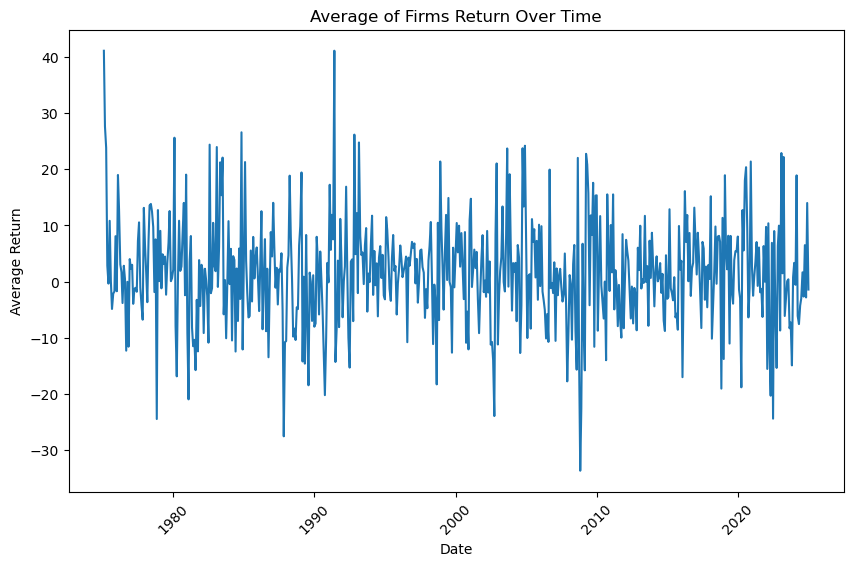

In [6]:
# Exploratory Data Analysis (EDA) on the returns data looking at the average market return per year
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleancrsp, x='date', y='ret', ci=None)
plt.title('Average of Firms Return Over Time')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.xticks(rotation=45)
plt.show()


In [7]:
cleancrsp['ret'].describe(percentiles=[.01, .05, .10, .25, .5, .75, .9, .95, .99, .995]) # check the distribution of returns

count    2497.000000
mean        1.613311
std        15.738224
min       -66.573800
1%        -36.856788
5%        -21.481520
10%       -14.941300
25%        -6.060600
50%         0.539100
75%         7.337300
90%        17.835280
95%        26.547200
99%        53.333592
99.5%      63.974036
max       147.058800
Name: ret, dtype: float64

In [8]:
cleancrsp['permno'].nunique() # check the number of unique permnos

cleancrsp['permno'].value_counts()


# profile = ProfileReport(cleancrsp, title="CRSP Data Profiling Report")


permno
61241    600
78837    333
87666    297
69060    206
17340    169
90316    154
14985    122
78850    111
79404    110
77652     79
40934     72
93235     55
28338     54
10181     46
21538     38
86096     27
24482     14
42076     10
Name: count, dtype: int64

In [41]:
# profile

In [7]:
import pandas_datareader as pdr
# load Fama-French factors

start = '1975-01-01'
start_date = datetime.strptime(start, '%Y-%m-%d')

# load Fama-French 5 factors
ff_5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date)[0]
ff_mom = pdr.get_data_famafrench('F-F_Momentum_Factor', start=start_date)[0]

# # load Fama-French factors
# df_factors = pdr.ff.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', start='1975-01-01').read()[0]

# # add momentum to this

ff_mom.columns = ['Mom'] # rename
ff_mom
ff_factors = pd.merge(ff_5, ff_mom, left_index=True, right_index=True)
# df_factors # FYI: contains Mkt-RF and RF, but no Mkt
#


In [8]:
ff_factors = ff_factors.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})

ff_factors
ff_factors["date"] = ff_factors["date"].dt.to_timestamp()

ff_factors["date"] = ff_factors["date"].apply(lambda x: x.replace(day=28))

# # # Then add the month offset
ff_factors["date"] = ff_factors["date"] + pd.DateOffset(months=1)

ff_factors
## will need to lag the signals and put the date to 28

,date,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,1975-02-28,13.66,12.91,8.28,-0.78,-0.90,0.58,-13.82
1,1975-03-28,5.56,-0.65,-4.45,1.16,-2.11,0.43,-0.61
2,1975-04-28,2.66,4.00,2.38,1.26,-1.33,0.41,-2.04
3,1975-05-28,4.23,-0.71,-1.14,1.41,-1.34,0.44,1.38
4,1975-06-28,5.19,2.89,-4.10,-0.98,-0.60,0.44,-0.58
...,...,...,...,...,...,...,...,...
595,2024-09-28,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
596,2024-10-28,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
597,2024-11-28,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87
598,2024-12-28,6.51,4.78,-0.05,-2.62,-2.17,0.40,0.90


## Open Signals from Zip

In [9]:
from zipfile import ZipFile


def open_dataframe_from_zip(zip_filepath, csv_filename):
    """
    Opens a Pandas DataFrame from a CSV file within a zip archive.

    Args:
        zip_filepath (str): Path to the zip file.
        csv_filename (str): Name of the CSV file inside the zip archive.

    Returns:
        pandas.DataFrame: The DataFrame read from the CSV file, or None if an error occurs.
    """
    try:
        with ZipFile(zip_filepath) as zf:
            with zf.open(csv_filename) as csvf:
                df = pd.read_csv(csvf)
        return df
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_filepath}'")
        return None
    except KeyError:
        print(f"Error: CSV file '{csv_filename}' not found in the zip archive.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage:
if DEV == False:
    zip_filepath = 'signed_predictors_dl_wide.zip'
    csv_filename = 'signed_predictors_dl_wide.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename)


    
# for speedy dev,
if DEV: 
    zip_filepath = 'signals.zip'
    csv_filename = 'signals.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename).drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1) # drop the unnamed column and date column
    # signals = signals.iloc[:,:20] # only take the first 20 columns for dev

if signals is not None:
    print(signals.head())

   permno        date  yyyymm_signals  AM  AOP  AbnormalAccruals  Accruals  \
0   10000  1986-02-28          198601 NaN  NaN               NaN       NaN   
1   10000  1986-03-28          198602 NaN  NaN               NaN       NaN   
2   10000  1986-04-28          198603 NaN  NaN               NaN       NaN   
3   10000  1986-05-28          198604 NaN  NaN               NaN       NaN   
4   10000  1986-06-28          198605 NaN  NaN               NaN       NaN   

   AccrualsBM  Activism1  Activism2  ...  AgeIPO  AnalystRevision  \
0         NaN        NaN        NaN  ...     NaN              NaN   
1         NaN        NaN        NaN  ...     NaN              NaN   
2         NaN        NaN        NaN  ...     NaN              NaN   
3         NaN        NaN        NaN  ...     NaN              NaN   
4         NaN        NaN        NaN  ...     NaN              NaN   

   AnalystValue  AnnouncementReturn  AssetGrowth  BM  BMdec  BPEBM  Beta  \
0           NaN                 NaN     

In [9]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273600 entries, 0 to 5273599
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   permno              int64  
 1   date                object 
 2   yyyymm_signals      int64  
 3   AM                  float64
 4   AOP                 float64
 5   AbnormalAccruals    float64
 6   Accruals            float64
 7   AccrualsBM          float64
 8   Activism1           float64
 9   Activism2           float64
 10  AdExp               float64
 11  AgeIPO              float64
 12  AnalystRevision     float64
 13  AnalystValue        float64
 14  AnnouncementReturn  float64
 15  AssetGrowth         float64
 16  BM                  float64
 17  BMdec               float64
 18  BPEBM               float64
 19  Beta                float64
 20  BetaFP              float64
dtypes: float64(18), int64(2), object(1)
memory usage: 844.9+ MB


In [24]:


# signals.to_csv('signals.csv')

# ## want to make this a zip file to push
# with ZipFile('signals.zip', 'w') as zf:
#     zf.write('signals.csv')

In [10]:
def move_column_to_front(df, columns):
    return df[columns + [col for col in df.columns if col not in columns]]  




In [11]:

signals = signals.rename(columns={'yyyymm': 'yyyymm_signals'})


    # Create date that is one month ahead for merging with returns
signals["yyyymm_signals"] = signals["yyyymm_signals"].astype(str) 
signals["date"] = pd.to_datetime(signals["yyyymm_signals"] + "28", format="%Y%m%d") + pd.DateOffset(months=1)




In [12]:
signals = move_column_to_front(signals, ['permno', 'date']) # lag signals by a month

signals.head()

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,10000,1986-02-28,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:


# create a new datetime column, use the year and month, but make the date 28th of the month:
cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_6273/2183361064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


## Need to Convert yyyymm column to yyyy-mm-dd datetime column, rename to date

Something interesting, the crsp dataset uses trading days. How do we get this in our signals dataset. Just go off year-months?

Can we merge on yyyy-mm and not include dd so that we can match the crsp dates? But how would it know the date in the future? For instance, would it know the end of the month a year from now, or guess based on the previous crsp dd for that year or month before?

Is lagging the signals the right thing to do or do I lag the returns??


value weighting 


In [14]:
bigdata = cleancrsp.merge(signals, on=['permno', 'date'], how='left', indicator=True, validate="one_to_one") 
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,_merge
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612,both
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669,both
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866,both
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028,both


In [15]:
bigdata = bigdata.merge(ff_factors, on='date', how='left', validate="many_to_one") # merge with Fama-French factors
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,0.087931,0.144612,both,0.43,-1.08,4.93,2.13,1.92,0.00,-3.29
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,0.029387,0.193669,both,-0.19,-4.11,1.17,3.47,1.00,0.00,-3.89
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,0.031067,0.210866,both,2.06,-1.89,-0.13,0.06,-1.00,0.00,0.87
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,0.042468,0.240028,both,2.61,3.10,-0.70,-1.88,-2.00,0.00,0.69


In [18]:
bigdata.columns[-7:]

Index(['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom'], dtype='object')

In [16]:
#combine

signal_list = bigdata.columns[3:] 

bigdata[signal_list].describe()

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,BPEBM,Beta,BetaFP,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
count,1704.000000,816.000000,1369.000000,1596.000000,265.000000,107.000000,11.000000,800.000000,256.000000,1563.000000,...,1704.000000,2201.000000,1987.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000
mean,3.135168,-2.559536,-0.002498,0.036187,0.298113,16.785047,11.931496,0.024550,31.500000,1.019391,...,-0.306544,1.171452,1.188292,0.762071,0.183471,0.271176,0.358359,0.257789,0.369807,0.618355
std,4.035629,4.657140,0.093481,0.103379,0.458295,1.189800,0.730371,0.042113,34.790465,1.106479,...,5.422417,0.733839,0.775232,4.506603,3.061735,3.128726,2.386691,2.071090,0.278721,4.288512
min,0.044649,-26.619371,-0.378753,-0.587368,0.000000,16.000000,9.738513,0.001219,0.000000,-9.571428,...,-109.735120,-0.419286,0.002696,-23.240000,-15.320000,-13.880000,-18.650000,-7.200000,0.000000,-34.300000
25%,0.707649,-2.447555,-0.053532,-0.019085,0.000000,16.000000,12.057259,0.005964,5.000000,0.980279,...,-0.412697,0.584052,0.567406,-1.920000,-1.540000,-1.540000,-0.760000,-1.000000,0.137500,-0.910000
50%,1.432095,-0.683316,-0.006319,0.042289,0.000000,16.000000,12.159690,0.011564,10.000000,1.000000,...,-0.031030,1.138633,1.084799,1.170000,0.070000,0.140000,0.300000,0.090000,0.390000,0.630000
75%,4.485829,-0.119619,0.054627,0.093920,1.000000,17.000000,12.202278,0.024305,60.250000,1.018167,...,0.032379,1.638533,1.714993,3.650000,1.920000,1.750000,1.360000,1.420000,0.490000,2.850000
max,26.594208,1.398652,0.286598,0.285369,1.000000,20.000000,12.250266,0.422114,102.000000,20.250000,...,66.705109,3.400727,3.841151,13.660000,18.280000,12.800000,13.070000,9.070000,1.350000,18.200000


In [17]:
# pretend its a dataframe grab the rows where the column is the name and make that a list

signal_documentation = pd.read_csv('SignalDoc.csv')
signal_documentation

# need to find a way to add the column type from cat. form to match the acronyms which are the columns of the dataset
signaldoc = signal_documentation[['Acronym', 'Cat.Form']].drop_duplicates()
signaldoc


,Acronym,Cat.Form
0,AbnormalAccruals,continuous
1,Accruals,continuous
2,AccrualsBM,discrete
3,Activism1,continuous
4,AM,continuous
...,...,...
326,SP_q,continuous
327,tang_q,continuous
328,Tax_q,continuous
329,WW_Q,continuous


In [18]:

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score


In [250]:
## First We need to split the data into train and test sets
## Don't use train, test, split

X = bigdata.drop(columns=['ret']) # drop the columns that are not needed
y = bigdata['ret'] # target variable

# split_date = '1990-12-28'

# train_data = X[X['date'] <= split_date]
# test_data = X[X['date'] > split_date]

# train_data = train_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# test_data = test_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# # check the number of rows in train and test data
# print(f"Train data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")



In [161]:
X

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,NaN,...,0.087931,0.144612,both,0.43,-1.08,4.93,2.13,1.92,0.00,-3.29
2493,93235,2014-05-28,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,NaN,...,0.029387,0.193669,both,-0.19,-4.11,1.17,3.47,1.00,0.00,-3.89
2494,93235,2014-06-28,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,NaN,...,0.031067,0.210866,both,2.06,-1.89,-0.13,0.06,-1.00,0.00,0.87
2495,93235,2014-07-28,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,NaN,...,0.042468,0.240028,both,2.61,3.10,-0.70,-1.88,-2.00,0.00,0.69


In [259]:
# Split the data into train and test sets based on date
X_train = X[X['date'] <= '2000-12-28']
X_test = X[(X['date'] > '2000-12-28') & (X['date'] <= '2001-12-28')]
y_train = y[X['date'] <= '2000-12-28']
y_test = y[(X['date'] > '2000-12-28') & (X['date'] <= '2001-12-28')]

In [260]:
X_train = X_train.reset_index(drop=True)
X_train

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,87666,2000-08-28,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.51,-1.03,8.31,5.83,2.94,0.48,-0.05
1461,87666,2000-09-28,200008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,7.03,-1.03,-1.39,-3.22,1.10,0.50,5.73
1462,87666,2000-10-28,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-5.45,0.19,7.17,2.56,5.53,0.51,1.97
1463,87666,2000-11-28,200010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.76,-2.65,5.71,9.61,3.80,0.56,-4.48


In [173]:
## Rolling Mean Imputer by Year

# X_train_reset = X_train.sort_values(['permno', 'date']).reset_index(drop=True) #not sure if this is needed for permno

# y_train_reset = y_train_reset.loc[X_train_reset.index]

def rolling_oos_cv(X_train, user_input, training_expanding_window_input):
    # Check user_input for date grouping
    
    # Year is the best, dont need months since it would be way too many splits
    time_groups = X_train.groupby(X_train['date'].dt.year).groups
    min_periods_in_train = user_input # Minimum number of periods in training set for each split
    # Debug: Check the user input
    print("User Input:", user_input)


    # Debug: Check the time_groups
    # print("Time Groups:", time_groups)
    
    # Check training_expanding_window_input
    if training_expanding_window_input == 'Expanding':
        training_expanding_window = True

    elif training_expanding_window_input == 'Rolling':
        training_expanding_window = False

    else:
        training_expanding_window = True
        print("Invalid input. Defaulting to Expanding.")

    # Prepare the sorted groups
    sorted_groups = [list(value) for (key, value) in sorted(time_groups.items())]


    # Generate cross-validation splits based on the window type
    if len(sorted_groups) < min_periods_in_train:
        print("Not enough groups to create the required number of splits.")
        return []

    if training_expanding_window:
        # Expanding window (generates training set that grows)
        cv = [(sorted([i for g in sorted_groups[:y] for i in g]), sorted(sorted_groups[y])) for y in range(min_periods_in_train, len(sorted_groups))]
    else:

        # Rolling window (fixed size training set)
        cv = [(sorted([i for g in sorted_groups[y - min_periods_in_train:y] for i in g]), sorted(sorted_groups[y])) for y in range(min_periods_in_train, len(sorted_groups))]

    return cv


cv_splits = rolling_oos_cv(X_train, 5, training_expanding_window_input='Expanding')
# Debug: Check the generated cross-validation splits
print("Generated Cross-Validation Splits:")
for train_indices, test_indices in cv_splits:
    print(f"Train indices: {train_indices[:5]}... Test indices: {test_indices[:5]}...")  # Print first 5 indices for brevity
# Check the number of splits
print(f"Number of splits generated: {len(cv_splits)}")
# Check the first split
print("First split:")
print(f"Train indices: {cv_splits[0][0][:5]}... Test indices: {cv_splits[0][1][:5]}...")  # Print first 5 indices for brevity
# Check the last split
print("Last split:")
print(f"Train indices: {cv_splits[-1][0][:5]}... Test indices: {cv_splits[-1][1][:5]}...")  # Print first 5 indices for brevity


# make sure groups are sorted


# entire market determines individual stock returns, pooled


User Input: 5
Generated Cross-Validation Splits:
Train indices: [46, 47, 48, 49, 50]... Test indices: [106, 107, 108, 109, 110]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [118, 119, 120, 121, 122]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [130, 131, 132, 133, 134]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [142, 143, 144, 145, 146]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [154, 155, 156, 157, 158]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [166, 167, 168, 169, 170]...
Train indices: [46, 47, 48, 49, 50]... Test indices: [0, 1, 2, 3, 4]...
Train indices: [0, 1, 2, 3, 4]... Test indices: [8, 9, 10, 11, 12]...
Train indices: [0, 1, 2, 3, 4]... Test indices: [20, 21, 22, 23, 24]...
Train indices: [0, 1, 2, 3, 4]... Test indices: [32, 33, 34, 35, 36]...
Train indices: [0, 1, 2, 3, 4]... Test indices: [44, 45, 531, 532, 533]...
Train indices: [0, 1, 2, 3, 4]... Test indices: [543, 544, 545, 546, 547]...
Train indices: [0, 1,

In [228]:
train_idx, val_idx = cv_splits[20]


In [229]:
train_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [230]:

X_train_fold = X_train.iloc[train_idx]
y_train_fold = y_train.iloc[train_idx]

X_val_fold = X_train.iloc[val_idx]
y_val_fold = y_train.iloc[val_idx]





# --- NEW ---
# Only validate on firms seen during training
# train_firms = set(X_train_fold['permno'])
# X_val_fold = X_val_fold[X_val_fold['permno'].isin(train_firms)]
# y_val_fold = y_val_fold.loc[X_val_fold.index]

# company delists after 1975 --> how do we handle this?

X_val_fold

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
651,61241,2000-01-28,199912,0.994592,-2.325438,-0.033396,0.086696,NaN,NaN,NaN,...,1.491114,1.513384,both,7.72,5.39,-8.33,-7.60,-5.63,0.44,13.22
652,61241,2000-02-28,200001,0.799472,-2.325438,-0.033396,0.086696,NaN,NaN,NaN,...,1.522286,1.402056,both,-4.74,4.42,-1.88,-6.29,4.72,0.41,1.92
653,61241,2000-03-28,200002,0.735617,-2.325438,-0.033396,0.086696,NaN,NaN,NaN,...,1.461076,1.358902,both,2.45,18.28,-9.59,-18.65,-0.48,0.43,18.20
654,61241,2000-04-28,200003,0.490318,-2.325438,-0.033396,0.086696,NaN,NaN,NaN,...,1.402972,1.379472,both,5.20,-15.32,8.13,11.79,-1.59,0.47,-6.83
655,61241,2000-05-28,200004,0.319757,-2.325438,-0.033396,0.086696,NaN,NaN,NaN,...,0.975457,1.284064,both,-6.40,-5.01,7.26,7.66,5.65,0.46,-8.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,87666,2000-08-28,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.51,-1.03,8.31,5.83,2.94,0.48,-0.05
1461,87666,2000-09-28,200008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,7.03,-1.03,-1.39,-3.22,1.10,0.50,5.73
1462,87666,2000-10-28,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-5.45,0.19,7.17,2.56,5.53,0.51,1.97
1463,87666,2000-11-28,200010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.76,-2.65,5.71,9.61,3.80,0.56,-4.48


In [274]:
from sklearn.base import BaseEstimator, TransformerMixin


class CrossSectionalMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute=None):
        
        self.features_to_impute = features_to_impute 

    def fit(self, X, y=None):
        # Nothing to fit — this imputer calculates means on the fly
        return self

    def transform(self, X):
        X = X.copy()
        
        # Make sure it's a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CrossSectionalMeanImputer only works on pandas DataFrames")
        
        # Check if index is a MultiIndex with 'date' as one of the levels
        if not isinstance(X.index, pd.MultiIndex) or 'date' not in X.index.names:
            raise ValueError("Input DataFrame must have a MultiIndex with 'date' as one of the levels")
    
        
        # Create a year variable
        X['_year'] = pd.to_datetime(X.index.get_level_values('date')).year.values
        
        # For each numeric column, fill NaNs with cross-sectional mean within each year
        # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        if self.features_to_impute is not None:
            cols_to_impute = [col for col in self.features_to_impute if col in X.columns]
        else:
            cols_to_impute = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        for col in cols_to_impute:
            col_global_mean = X[col].mean()
            
            # If the global mean itself is NaN, fallback to 0
            if pd.isna(col_global_mean):
                col_global_mean = 0.0
            
            def safe_fill(x):
                if x.isnull().all():
                    return x.fillna(col_global_mean)  # use fallback global mean (guaranteed non-NaN now)
                else:
                    return x.fillna(x.mean())  # cross-sectional mean
                
            X[col] = X.groupby('_year')[col].transform(safe_fill)
            
        X = X.drop(columns=['_year'])
        
        return X
        

In [275]:
from sklearn.linear_model import RidgeCV

# Set the index of X to permno and date

exclude = ['ret', 'yyyymm_signals', 'permno', '_merge'] # columns to exclude from the preprocessing pipe

continuous_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'continuous', 'Acronym'].tolist() + ['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'Mom'] # convert df to list to get columns for preprocessing pipe
# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom' are the Five Fama-French factors and momentum factor
discrete_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'discrete', 'Acronym'].tolist() # convert df to list to get columns for preprocessing pipe



continuous_cols = [col for col in continuous_cols if col in X.columns and col not in exclude] # filter out columns that are not in X
discrete_cols = [col for col in discrete_cols if col in X.columns and col not in exclude] # filter out columns that are not in X

numer_pipe = make_pipeline(CrossSectionalMeanImputer(features_to_impute=continuous_cols),
                           StandardScaler()) 

cat_pipe   = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # drop first to avoid dummy variable trap


preproc_pipe = ColumnTransformer(
    transformers=[
        ('numbers', numer_pipe, continuous_cols),  
        ('categoricals', cat_pipe, discrete_cols), 
    ],
    remainder='drop'  
)



from df_after_transform import df_after_transform

if X_train.index.nlevels != 2 or 'date' not in X_train.index.names:
    X_train = X_train.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
else:
    X_train = X_train.copy()
# make sure the index is a MultiIndex with permno and date

preproc_df = df_after_transform(preproc_pipe,X_train) #only fill on the training set --> data leakage could be introduced if we fill on the entire dataset
preproc_df
print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2)
# model_pipe.fit(,



There are 25 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
AbnormalAccruals,1465.0,-0.00,1.00,-2.60,-0.42,-0.03,0.37,4.77
Accruals,1465.0,-0.00,1.00,-2.60,-0.59,-0.04,0.66,3.17
Activism1,1465.0,-0.00,1.00,-0.96,-0.47,-0.06,-0.06,3.79
AM,1465.0,-0.00,1.00,-0.93,-0.70,-0.33,0.36,5.49
AnalystRevision,1465.0,-0.00,1.00,-17.18,-0.03,0.01,0.06,22.78
AnnouncementReturn,1465.0,0.00,1.00,-5.47,-0.43,-0.02,0.44,4.67
AssetGrowth,1465.0,0.00,1.00,-3.91,-0.51,-0.03,0.70,3.71
BM,1465.0,0.00,1.00,-2.68,-0.79,-0.09,0.72,2.53
BMdec,1465.0,-0.00,1.00,-1.30,-0.66,-0.29,0.45,5.32
BPEBM,1465.0,-0.00,1.00,-11.59,-0.14,0.06,0.09,17.24


In [276]:
# Reset the index to rows to ensure the folds are possible but keep permno and date as columns but don't add another index
X_train = X_train.reset_index()  # reset index to rows




In [277]:
X_train 

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,87666,2000-08-28,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.51,-1.03,8.31,5.83,2.94,0.48,-0.05
1461,87666,2000-09-28,200008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,7.03,-1.03,-1.39,-3.22,1.10,0.50,5.73
1462,87666,2000-10-28,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-5.45,0.19,7.17,2.56,5.53,0.51,1.97
1463,87666,2000-11-28,200010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.76,-2.65,5.71,9.61,3.80,0.56,-4.48


In [237]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),  # 3 layers: 256 → 128 → 64 nodes
    activation='relu',
    solver='adam',
    alpha=1e-6,            # L2 penalty (like weight decay)
    batch_size=512,
    learning_rate='adaptive',  # lowers learning rate when no improvement
    learning_rate_init=0.0001,
    max_iter=100,
    early_stopping=True,   # Very important to avoid overfitting
    validation_fraction=0.1,  # 10% of training data used for validation internally
    random_state=42,
    verbose=True           # See training progress
)

In [238]:
X_train

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,87666,2000-08-28,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.51,-1.03,8.31,5.83,2.94,0.48,-0.05
1461,87666,2000-09-28,200008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,7.03,-1.03,-1.39,-3.22,1.10,0.50,5.73
1462,87666,2000-10-28,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-5.45,0.19,7.17,2.56,5.53,0.51,1.97
1463,87666,2000-11-28,200010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-2.76,-2.65,5.71,9.61,3.80,0.56,-4.48


In [279]:
model_pipe = make_pipeline(
    preproc_pipe,
    mlp
)


oof_predictions = np.zeros(len(X_train))  # "Out-of-fold" predictions
oof_true = np.zeros(len(X_train))          # True y values aligned to validation folds

for fold, (train_idx, val_idx) in enumerate(cv_splits):
    
    print(f"Training fold {fold+1}/{len(cv_splits)}...")
  
    # Split into training and validation sets
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    # Apply preprocessing pipeline to training and validation folds
    # Special note: if you're using a CrossSectionalMeanImputer, 
    # you should fit() it on training set only if it was outside pipeline.
    # But in your case it's inside the preproc_pipe, so fine.

    X_train_fold = X_train_fold.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
    
    X_val_fold = X_val_fold.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
    
    # Train the pipeline on the training fold
    model_pipe.fit(X_train_fold, y_train_fold)
    
    # Predict on validation fold
    val_preds = model_pipe.predict(X_val_fold)
    
    # Save predictions
    oof_predictions[val_idx] = val_preds
    oof_true[val_idx] = y_val_fold



Training fold 1/21...
Iteration 1, loss = 168.00423092
Validation score: -0.004610
Iteration 2, loss = 167.80815482
Validation score: -0.004410
Iteration 3, loss = 167.61741996
Validation score: -0.004237
Iteration 4, loss = 167.43096039
Validation score: -0.004086
Iteration 5, loss = 167.24671298
Validation score: -0.003944
Iteration 6, loss = 167.06353534
Validation score: -0.003812
Iteration 7, loss = 166.88213223
Validation score: -0.003702
Iteration 8, loss = 166.70101721
Validation score: -0.003628
Iteration 9, loss = 166.52117997
Validation score: -0.003564
Iteration 10, loss = 166.34581924
Validation score: -0.003502
Iteration 11, loss = 166.17211249
Validation score: -0.003436
Iteration 12, loss = 166.00010522
Validation score: -0.003364
Iteration 13, loss = 165.82923533
Validation score: -0.003314


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 14, loss = 165.66329129
Validation score: -0.003272
Iteration 15, loss = 165.50003894
Validation score: -0.003221
Iteration 16, loss = 165.33936927
Validation score: -0.003178
Iteration 17, loss = 165.18315985
Validation score: -0.003163
Iteration 18, loss = 165.02784557
Validation score: -0.003156
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training fold 2/21...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 170.28939723
Validation score: -0.114433
Iteration 2, loss = 170.12445233
Validation score: -0.113682
Iteration 3, loss = 169.96250454
Validation score: -0.112943
Iteration 4, loss = 169.80357271
Validation score: -0.112237
Iteration 5, loss = 169.64662792
Validation score: -0.111540
Iteration 6, loss = 169.49148666
Validation score: -0.110847
Iteration 7, loss = 169.33821330
Validation score: -0.110165
Iteration 8, loss = 169.18655000
Validation score: -0.109483
Iteration 9, loss = 169.03659401
Validation score: -0.108786
Iteration 10, loss = 168.88866031
Validation score: -0.108102
Iteration 11, loss = 168.74293409
Validation score: -0.107435
Iteration 12, loss = 168.60052085
Validation score: -0.106787
Iteration 13, loss = 168.46305518
Validation score: -0.106143
Iteration 14, loss = 168.32629068
Validation score: -0.105506
Iteration 15, loss = 168.19191785
Validation score: -0.104875
Iteration 16, loss = 168.05921678
Validation score: -0.104258
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Training fold 3/21...
Iteration 1, loss = 174.56168917
Validation score: -0.012255
Iteration 2, loss = 174.43592940
Validation score: -0.012147
Iteration 3, loss = 174.31154336
Validation score: -0.012069
Iteration 4, loss = 174.18898179
Validation score: -0.012011
Iteration 5, loss = 174.06910227
Validation score: -0.011962
Iteration 6, loss = 173.94965250
Validation score: -0.011920
Iteration 7, loss = 173.83127151
Validation score: -0.011858
Iteration 8, loss = 173.71344193
Validation score: -0.011791
Iteration 9, loss = 173.59747028
Validation score: -0.011693
Iteration 10, loss = 173.48287527
Validation score: -0.011609
Iteration 11, loss = 173.37099553
Validation score: -0.011536
Iteration 12, loss = 173.26002445
Validation score: -0.011441
Iteration 13, loss = 173.15057948
Validation score: -0.011324
Iteration 14, loss = 173.04154396
Validation score: -0.011204
Iteration 15, loss = 172.93297176
Validation score: -0.011077
Iteration 16, loss = 172.82541648
Validation score: -0.01

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 178.09482185
Validation score: -0.026947
Iteration 2, loss = 177.98266644
Validation score: -0.026458
Iteration 3, loss = 177.87272491
Validation score: -0.025984
Iteration 4, loss = 177.76436648
Validation score: -0.025523
Iteration 5, loss = 177.65755633
Validation score: -0.025078
Iteration 6, loss = 177.55323950
Validation score: -0.024643
Iteration 7, loss = 177.44939050
Validation score: -0.024226
Iteration 8, loss = 177.34706872
Validation score: -0.023818
Iteration 9, loss = 177.24603545
Validation score: -0.023396
Iteration 10, loss = 177.14683344
Validation score: -0.022994
Iteration 11, loss = 177.04873635
Validation score: -0.022610
Iteration 12, loss = 176.95223096
Validation score: -0.022228
Iteration 13, loss = 176.85796747
Validation score: -0.021862
Iteration 14, loss = 176.76539658
Validation score: -0.021499
Iteration 15, loss = 176.67347162
Validation score: -0.021142
Iteration 16, loss = 176.58172200
Validation score: -0.020790
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 176.44974162
Validation score: -0.007514
Iteration 2, loss = 176.31828700
Validation score: -0.007460
Iteration 3, loss = 176.18912860
Validation score: -0.007404
Iteration 4, loss = 176.06180053
Validation score: -0.007337
Iteration 5, loss = 175.93695832
Validation score: -0.007275
Iteration 6, loss = 175.81451401
Validation score: -0.007239
Iteration 7, loss = 175.69378773
Validation score: -0.007202
Iteration 8, loss = 175.57369370
Validation score: -0.007172
Iteration 9, loss = 175.45519632
Validation score: -0.007153
Iteration 10, loss = 175.33956067
Validation score: -0.007149
Iteration 11, loss = 175.22480883
Validation score: -0.007158
Iteration 12, loss = 175.11262439
Validation score: -0.007178
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training fold 6/21...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 158.63418433
Validation score: -0.142288
Iteration 2, loss = 158.54618615
Validation score: -0.141368
Iteration 3, loss = 158.45885420
Validation score: -0.140457
Iteration 4, loss = 158.37261751
Validation score: -0.139543
Iteration 5, loss = 158.28877723
Validation score: -0.138641
Iteration 6, loss = 158.20710068
Validation score: -0.137744
Iteration 7, loss = 158.12724743
Validation score: -0.136850
Iteration 8, loss = 158.04876442
Validation score: -0.135981
Iteration 9, loss = 157.97107259
Validation score: -0.135122
Iteration 10, loss = 157.89415791
Validation score: -0.134279
Iteration 11, loss = 157.81863646
Validation score: -0.133462
Iteration 12, loss = 157.74464413
Validation score: -0.132659
Iteration 13, loss = 157.67155630
Validation score: -0.131865
Iteration 14, loss = 157.59924608
Validation score: -0.131078
Iteration 15, loss = 157.52745340
Validation score: -0.130299
Iteration 16, loss = 157.45621920
Validation score: -0.129527
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 168.13019794
Validation score: -0.014384
Iteration 2, loss = 168.02426963
Validation score: -0.014204
Iteration 3, loss = 167.91942059
Validation score: -0.014046
Iteration 4, loss = 167.81617828
Validation score: -0.013883
Iteration 5, loss = 167.71416567
Validation score: -0.013735
Iteration 6, loss = 167.61265292
Validation score: -0.013597
Iteration 7, loss = 167.51130225
Validation score: -0.013477
Iteration 8, loss = 167.41128382
Validation score: -0.013365
Iteration 9, loss = 167.31247710
Validation score: -0.013277
Iteration 10, loss = 167.21428058
Validation score: -0.013194
Iteration 11, loss = 167.11780327
Validation score: -0.013100
Iteration 12, loss = 167.02231994
Validation score: -0.013003
Iteration 13, loss = 166.92792395
Validation score: -0.012891
Iteration 14, loss = 166.83440617
Validation score: -0.012791
Iteration 15, loss = 166.74289575
Validation score: -0.012700
Iteration 16, loss = 166.65284334
Validation score: -0.012617
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 152.16545407
Validation score: -0.042361
Iteration 2, loss = 152.03659045
Validation score: -0.041541
Iteration 3, loss = 151.93764243
Validation score: -0.040648
Iteration 4, loss = 151.84719686
Validation score: -0.039738
Iteration 5, loss = 151.75237969
Validation score: -0.038848
Iteration 6, loss = 151.67197162
Validation score: -0.038091
Iteration 7, loss = 151.58756762
Validation score: -0.037462
Iteration 8, loss = 151.51605748
Validation score: -0.036934
Iteration 9, loss = 151.44317027
Validation score: -0.036510
Iteration 10, loss = 151.38074903
Validation score: -0.036093
Iteration 11, loss = 151.31544116
Validation score: -0.035693
Iteration 12, loss = 151.25287233
Validation score: -0.035298
Iteration 13, loss = 151.18913653
Validation score: -0.034904
Iteration 14, loss = 151.12205667
Validation score: -0.034465
Iteration 15, loss = 151.05989841
Validation score: -0.033971
Iteration 16, loss = 150.99301652
Validation score: -0.033433
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 152.07750256
Validation score: -0.001562
Iteration 2, loss = 151.93067957
Validation score: -0.001323
Iteration 3, loss = 151.82778203
Validation score: -0.001092
Iteration 4, loss = 151.72126441
Validation score: -0.000853
Iteration 5, loss = 151.63106959
Validation score: -0.000630
Iteration 6, loss = 151.53093498
Validation score: -0.000387
Iteration 7, loss = 151.44232160
Validation score: -0.000130
Iteration 8, loss = 151.35967752
Validation score: 0.000102
Iteration 9, loss = 151.27259487
Validation score: 0.000326
Iteration 10, loss = 151.19969085
Validation score: 0.000539
Iteration 11, loss = 151.11412222
Validation score: 0.000774
Iteration 12, loss = 151.02818627
Validation score: 0.000992
Iteration 13, loss = 150.95729836
Validation score: 0.001207
Iteration 14, loss = 150.88102823
Validation score: 0.001432
Iteration 15, loss = 150.79950078
Validation score: 0.001668
Iteration 16, loss = 150.72800108
Validation score: 0.001927
Iteration 17, loss = 150.6

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 161.95252623
Validation score: -0.002403
Iteration 2, loss = 161.82354159
Validation score: -0.002288
Iteration 3, loss = 161.70155043
Validation score: -0.002201
Iteration 4, loss = 161.61314352
Validation score: -0.002160
Iteration 5, loss = 161.49014109
Validation score: -0.002113
Iteration 6, loss = 161.41471468
Validation score: -0.002037
Iteration 7, loss = 161.31216365
Validation score: -0.001974
Iteration 8, loss = 161.21747656
Validation score: -0.001883
Iteration 9, loss = 161.13713069
Validation score: -0.001770
Iteration 10, loss = 161.03835699
Validation score: -0.001653
Iteration 11, loss = 160.95799915
Validation score: -0.001509
Iteration 12, loss = 160.87303984
Validation score: -0.001361
Iteration 13, loss = 160.78766970
Validation score: -0.001217
Iteration 14, loss = 160.70947662
Validation score: -0.001070
Iteration 15, loss = 160.63178473
Validation score: -0.000924
Iteration 16, loss = 160.55367168
Validation score: -0.000794
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 162.45788527
Validation score: -0.009212
Iteration 2, loss = 162.32007279
Validation score: -0.009365
Iteration 3, loss = 162.20304317
Validation score: -0.009527
Iteration 4, loss = 162.07728703
Validation score: -0.009684
Iteration 5, loss = 161.97211919
Validation score: -0.009863
Iteration 6, loss = 161.86396231
Validation score: -0.010028
Iteration 7, loss = 161.75670307
Validation score: -0.010171
Iteration 8, loss = 161.65724567
Validation score: -0.010327
Iteration 9, loss = 161.54909179
Validation score: -0.010474
Iteration 10, loss = 161.44946500
Validation score: -0.010571
Iteration 11, loss = 161.35856859
Validation score: -0.010665
Iteration 12, loss = 161.26282087
Validation score: -0.010723
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training fold 14/21...
Iteration 1, loss = 166.13033718
Validation score: -0.006569
Iteration 2, loss = 165.99441405
Validation score: -0.006471
Iteration 3, loss = 165.850

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 155.01684857
Validation score: -0.023348
Iteration 2, loss = 154.88576705
Validation score: -0.022879
Iteration 3, loss = 154.76719887
Validation score: -0.022427
Iteration 4, loss = 154.65773750
Validation score: -0.021998
Iteration 5, loss = 154.53186721
Validation score: -0.021611
Iteration 6, loss = 154.43479328
Validation score: -0.021221
Iteration 7, loss = 154.33879437
Validation score: -0.020845
Iteration 8, loss = 154.23357896
Validation score: -0.020477
Iteration 9, loss = 154.13627819
Validation score: -0.020116
Iteration 10, loss = 154.04071475
Validation score: -0.019749
Iteration 11, loss = 153.95008457
Validation score: -0.019396
Iteration 12, loss = 153.85023344
Validation score: -0.019058
Iteration 13, loss = 153.75689129
Validation score: -0.018714
Iteration 14, loss = 153.66315033
Validation score: -0.018401
Iteration 15, loss = 153.57604936
Validation score: -0.018076
Iteration 16, loss = 153.47516021
Validation score: -0.017778
Iteration 17, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 152.59508954
Validation score: -0.000974
Iteration 2, loss = 152.40045765
Validation score: -0.001139
Iteration 3, loss = 152.26162688
Validation score: -0.001446
Iteration 4, loss = 152.10867154
Validation score: -0.001713
Iteration 5, loss = 151.96557619
Validation score: -0.001972
Iteration 6, loss = 151.84568433
Validation score: -0.002267
Iteration 7, loss = 151.70993182
Validation score: -0.002543
Iteration 8, loss = 151.59236150
Validation score: -0.002751
Iteration 9, loss = 151.47283979
Validation score: -0.002852
Iteration 10, loss = 151.37055491
Validation score: -0.002968
Iteration 11, loss = 151.26192411
Validation score: -0.003039
Iteration 12, loss = 151.16537606
Validation score: -0.003169
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training fold 19/21...
Iteration 1, loss = 134.55428956
Validation score: -0.011857
Iteration 2, loss = 134.38241348
Validation score: -0.011431
Iteration 3, loss = 134.244

In [280]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Compute errors
mse = mean_squared_error(y_val_fold, val_preds)
rmse = mse ** 0.5
mae = mean_absolute_error(y_val_fold, val_preds)
r2 = r2_score(y_val_fold, val_preds)

print(f"Validation MSE: {mse:.6f}")
print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation MAE: {mae:.6f}")
print(f"Validation R²: {r2:.4f}")


Validation MSE: 330.909174
Validation RMSE: 18.190909
Validation MAE: 13.260386
Validation R²: 0.0041


In [272]:
for fold, (train_idx, val_idx) in enumerate(cv_splits):
    print(fold)
    print(train_idx[:5])
    print(val_idx[-5:])
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    X_train_fold = X_train_fold.set_index(['permno', 'date'])  # if not already
    X_val_fold = X_val_fold.set_index(['permno', 'date'])  # if not already
    X_train_fold_scaled = preproc_pipe.transform(X_train_fold)
    X_val_fold_scaled = preproc_pipe.transform(X_val_fold)
    

    X_train_fold_scaled = X_train_fold_scaled.to_frame()
    X_val_fold_scaled = X_val_fold_scaled.to_frame()

    # Fit the model on the training fold
    model_pipe.fit(X_train_fold_scaled, y_train_fold)
    

0
[46, 47, 48, 49, 50]
[1008, 1009, 1010, 1011, 1012]


AttributeError: 'numpy.ndarray' object has no attribute 'to_frame'

In [273]:
X_train_fold_scaled

array([[-0.04287285,  0.73682304,         nan, ..., -0.63211288,
         1.        ,  0.        ],
       [-0.04287285,  0.73682304,         nan, ..., -4.57366828,
         1.        ,  0.        ],
       [-0.04287285,  0.73682304,         nan, ..., -0.36387882,
         1.        ,  0.        ],
       ...,
       [ 0.75578726,  0.00833149,         nan, ...,  1.51315826,
         1.        ,  0.        ],
       [ 0.75578726,  0.00833149,         nan, ...,  0.47106806,
         1.        ,  0.        ],
       [ 0.75578726,  0.00833149,         nan, ...,  2.42458883,
         1.        ,  0.        ]])

In [268]:
print("X_train_fold columns:", X_train_fold.columns.tolist())


X_train_fold columns: ['yyyymm_signals', 'AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP', '_merge', 'mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom']


In [240]:
# Get preprocessed X_val_fold
X_val_fold_transformed = model_pipe[:-1].transform(X_val_fold)

# Check total number of NaNs
print(f"Fold {fold+1} - Total NaNs after preprocessing:", np.isnan(X_val_fold_transformed).sum())



Fold 1 - Total NaNs after preprocessing: 198


In [241]:
X_train_fold

yyyymm_signals        AM  AOP  AbnormalAccruals  Accruals  \
permno date                                                                   
17340  1975-01-28         197412  9.920516  NaN         -0.021073  0.040496   
       1975-02-28         197501  8.461616  NaN         -0.021073  0.040496   
       1975-03-28         197502  7.991527  NaN         -0.021073  0.040496   
       1975-04-28         197503  6.254238  NaN         -0.021073  0.040496   
       1975-05-28         197504  5.271287  NaN         -0.021073  0.040496   
...                          ...       ...  ...               ...       ...   
78837  1979-08-28         197907       NaN  NaN               NaN       NaN   
       1979-09-28         197908       NaN  NaN               NaN       NaN   
       1979-10-28         197909       NaN  NaN               NaN       NaN   
       1979-11-28         197910       NaN  NaN               NaN       NaN   
       1979-12-28         197911       NaN  NaN               NaN       NaN   

                   AccrualsBM  Activism1  Activism2  AdExp  AgeIPO  ...  \
permno date                                                         ...   
17340  1975-01-28         NaN        NaN        NaN    NaN     NaN  ...   
       1975-02-28         NaN        NaN        NaN    NaN     NaN  ...   
       1975-03-28         NaN        NaN        NaN    NaN     NaN  ...   
       1975-04-28         NaN        NaN        NaN    NaN     NaN  ...   
       1975-05-28         NaN        NaN        NaN    NaN     NaN  ...   
...                       ...        ...        ...    ...     ...  ...   
78837  1979-08-28         NaN        NaN        NaN    NaN     NaN  ...   
       1979-09-28         NaN        NaN        NaN    NaN     NaN  ...   
       1979-10-28         NaN        NaN        NaN    NaN     NaN  ...   
       1979-11-28         NaN        NaN        NaN    NaN     NaN  ...   
       1979-12-28         NaN        NaN        NaN    NaN     NaN  ...   

                       Beta    BetaFP  _merge  mkt_excess    SMB   HML   RMW  \
permno date                                                                    
17340  1975-01-28  1.405766  2.012820    both         NaN    NaN   NaN   NaN   
       1975-02-28  1.179606  1.968010    both       13.66  12.91  8.28 -0.78   
       1975-03-28  1.177120  1.978824    both        5.56  -0.65 -4.45  1.16   
       1975-04-28  1.216368  2.014412    both        2.66   4.00  2.38  1.26   
       1975-05-28  1.226384  1.995616    both        4.23  -0.71 -1.14  1.41   
...                     ...       ...     ...         ...    ...   ...   ...   
78837  1979-08-28  0.054663  0.122513    both        0.82   1.27  1.86 -0.29   
       1979-09-28  0.046428  0.080502    both        5.53   1.92 -1.58  1.62   
       1979-10-28  0.052922  0.086437    both       -0.82  -0.32 -0.90  1.01   
       1979-11-28  0.059120  0.091448    both       -8.10  -3.50 -1.84  1.01   
       1979-12-28  0.035538  0.057102    both        5.21   2.53 -3.29  0.06   

                    CMA    RF    Mom  
permno date                           
17340  1975-01-28   NaN   NaN    NaN  
       1975-02-28 -0.90  0.58 -13.82  
       1975-03-28 -2.11  0.43  -0.61  
       1975-04-28 -1.33  0.41  -2.04  
       1975-05-28 -1.34  0.44   1.38  
...                 ...   ...    ...  
78837  1979-08-28  0.71  0.77  -1.07  
       1979-09-28 -1.48  0.77  -0.20  
       1979-10-28  0.32  0.83   5.28  
       1979-11-28  0.07  0.87   2.01  
       1979-12-28 -2.12  0.99   8.14  

[253 rows x 27 columns]

In [225]:
# Get preprocessed X_val_fold
X_train_fold_transformed = model_pipe[:-1].transform(X_train_fold)

# Check total number of NaNs
print(f"Fold {fold+1} - Total NaNs after preprocessing:", np.isnan(X_val_fold_transformed).sum())


Fold 1 - Total NaNs after preprocessing: 198


In [ ]:
## Rolling OOS Function

# adjust the inside of "groupby()" to your df/problem, pick other parameters

time_groups               = X_train.groupby(X_train['DATE'].dt.year).groups 
min_periods_in_train      = 5
training_expanding_window = True

# shouldn't need to adjust this code: 

sorted_groups = [list(value) for (key, value) in sorted(time_groups.items())]

if training_expanding_window:

    cv = [([i for g in sorted_groups[:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train , len(sorted_groups))]

else:
    
    cv = [([i for g in sorted_groups[y-min_periods_in_train:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train, len(sorted_groups))]
    
def rolling_oos()

In [39]:

# Assuming your dataframe is called 'returns_df' with a 'Date' column
# and is already sorted by date

def rolling_validation(df, feature_cols, target_col, 
                       train_window=12, test_window=1, 
                       model_func=None):
    """
    Perform rolling window validation.
    
    Parameters:
    - df: DataFrame with time-series data
    - feature_cols: List of column names for features
    - target_col: Column name for target variable
    - train_window: Number of periods for training (e.g., 12 months)
    - test_window: Number of periods for testing (e.g., 1 month)
    - model_func: Function that takes X_train, y_train and returns a fitted model
    
    Returns:
    - Dictionary with performance metrics
    """
    results = {
        'dates': [],
        'r2': [],
        'predictions': [],
        'actuals': []
    }
    
    # Get the unique dates in your dataset
    dates = df['date'].unique()
    
    
    # Make sure we have enough data for at least one validation cycle
    if len(dates) < train_window + test_window:
        raise ValueError("Not enough time periods for specified windows")
    
    # Loop through time periods for rolling validation
    for i in range(len(dates) - train_window - test_window + 1):
        # Define training and testing periods
        train_start = i
        train_end = i + train_window
        test_start = train_end
        test_end = test_start + test_window
        
        train_dates = dates[train_start:train_end]
        test_dates = dates[test_start:test_end]
        
        # Get training and testing data
        train_mask = df['date'].isin(train_dates)
        test_mask = df['date'].isin(test_dates)
        
        X_train = df.loc[train_mask, feature_cols]
        y_train = df.loc[train_mask, target_col]
        X_test = df.loc[test_mask, feature_cols]
        y_test = df.loc[test_mask, target_col]
        
        # Train model
        model = model_func(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
       
        
        # Store results
        results['dates'].append(test_dates[-1])
        results['r2'].append(r2)
 
        results['predictions'].extend(y_pred)
        results['actuals'].extend(y_test)
        
    return results

# Example usage
def train_model(X, y):
    # Replace this with your actual model
    #import MLPRegressor
    from sklearn.neural_network import MLPRegressor
    
    # Using a Multi-layer Perceptron Regressor as an example
    # Adjust the parameters based on your specific needs

    model = MLPRegressor(
        hidden_layer_sizes=(32, 16, 8),  # Increase neurons for more learning capacity
        activation="relu",  # Good for nonlinear relationships
        solver="adam",  # Robust optimizer for noisy data
        alpha=0.001,  # Add regularization to reduce overfitting
        batch_size=10000,
        learning_rate_init=0.01,  # Lower learning rate for finer optimization
        max_iter=100,  # Allow more iterations for convergence
        early_stopping=True,  # Stop training if validation error doesn't improve
        n_iter_no_change=5,  # Patience for early stopping
        random_state=1,  # Ensure reproducibility
        )
    model.fit(X, y)
    return model

# Define your feature columns and target
feature_cols = preproc_df.columns.to_list()  # Your features
target_col = ['ret']  # Your target

# Run rolling validation
results = rolling_validation(bigdata, feature_cols, target_col, 
                            train_window=12, test_window=1, 
                            model_func=train_model)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(results['dates'], results['r2'], label='R² Score')
plt.title('Rolling Validation Performance')
plt.xlabel('Test Period End Date')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "['AccrualsBM_0.0', 'AccrualsBM_1.0', 'AccrualsBM_nan'] not in index"

In [ ]:
# Generate cleaned data with all of the preprocessing tools above
# preproc_pipe.fit(bigdata[for signal in signal_list if signal in bigdata], bigdata['ret'])

## get the proper columns for the model
X = bigdata[signal_list]


,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,5.169856,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612
2493,4.409937,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669
2494,4.468319,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866
2495,4.224629,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028


# OLS -- ML Style Portfolios

In [ ]:
fit_start = 1975
fit_end = 1990

## Want to find a better way to split and test the model
n_portfolios = 5



In [37]:
signal_list

Index(['yyyymm_signals', 'AM', 'AOP', 'AbnormalAccruals', 'Accruals',
       'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO',
       'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth',
       'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP'],
      dtype='object')